In [61]:
#pytorch
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models

# general
import os
from collections import defaultdict
import time
import json
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score

## Загрузка данных 

In [62]:
batch_size = 4

In [63]:
data_transforms = \
{
    'train': 
    [
#         transforms.CenterCrop(224),
        transforms.Resize(300),
        transforms.CenterCrop(300),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ],
    'test': 
    [
        transforms.Resize(300),
        transforms.CenterCrop(300),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
}

### Default  

In [64]:
paths = {
    "train" : "img/train",
    "test" : "img/test"
}

In [65]:
image_datasets = {x: ImageFolder(paths[x], transforms.Compose(data_transforms[x])) for x in ['train', 'test']}

In [66]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

In [67]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
dataset_sizes

{'train': 6710, 'test': 3305}

###  Enriched

In [31]:
paths = {
    "train" : "img/train_enriched",
    "test" : "img/test"
}

In [32]:
image_datasets = {x: ImageFolder(paths[x], transforms.Compose(data_transforms[x])) for x in ['train', 'test']}

In [33]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'test']}

In [34]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
dataset_sizes

{'train': 35832, 'test': 3305}

## Device

In [68]:
class_names = image_datasets['train'].classes
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Визуализация 

In [70]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    
    #revert normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

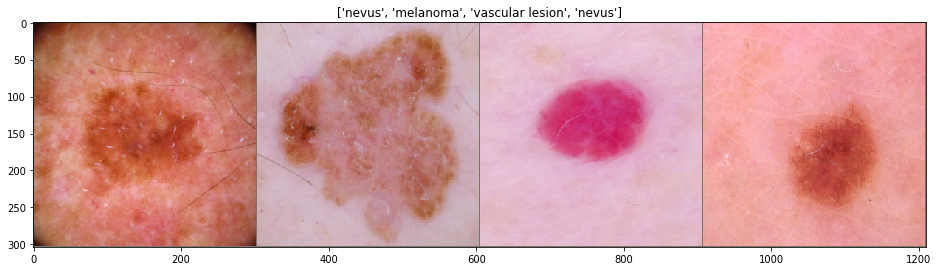

In [71]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Функции обучения и валидации


In [72]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, print_log=True):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    stat_dict = {
        "train" :{
            "epoch" : [],
            "loss" : [],
            "acc" : []
        },
        "test" :{
            "epoch" : [],
            "loss" : [],
            "acc" : []
        }
    }


    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            is_train_phase = (phase == "train")
            model.train(is_train_phase)
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(is_train_phase):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if is_train_phase:
                        loss.backward()
                        optimizer.step()

                # statistics inputs.size(0) = batch_size 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if is_train_phase:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            stat_dict[phase]["epoch"].append(epoch)
            stat_dict[phase]["loss"].append(epoch_loss)
            stat_dict[phase]["acc"].append(epoch_acc.item())
            
            if print_log:
                print(f"{phase} Loss: {epoch_loss : .4f} Acc: {epoch_acc : .4f}")
                time_elapsed = time.time() - start_time
                print(f"Time passed {time_elapsed // 60 : .0f} m {time_elapsed % 60 : .0f} s")
                
            # deep copy the model
            if (not is_train_phase) and (epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed // 60 : .0f}m {time_elapsed % 60 : .0f}s")
    print(f"Best val Acc: {best_acc : .4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, stat_dict

In [73]:
def valid_model(model, print_log=True):
    result_dict = {
        "real" : [],
        "predicted" : []
    }

    with torch.no_grad():
        for images, labels in dataloaders["test"]:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
                result_dict["real"].append(class_names[labels[i]])
                result_dict["predicted"].append(class_names[predicted[i]])

    result_df = pd.DataFrame(result_dict)
    result_df["answer"] = result_df.apply(lambda x: int(x["real"] == x["predicted"]), axis=1)

    acc_dict = {}
    total_acc = accuracy_score(result_df["real"], result_df["predicted"]) * 100
    acc_dict["total"] = total_acc
    
    if print_log:
        print(f"Total accuracy: {round(total_acc, 2)}%")

    for img_class in result_df["real"].unique():
        class_df = result_df[result_df["real"] == img_class]
        class_acc = accuracy_score(class_df["real"], class_df["predicted"]) * 100
        acc_dict[img_class] = class_acc
        if print_log:
            print(f"\t{img_class} ({len(class_df)}) : {round(class_acc, 2)}%")
    
    return acc_dict

## Обучение 

In [74]:
def convert_score_to_df(score_dict):
    data = defaultdict(list)
    first = list(score_dict.keys())[0]
    for scope in score_dict[first]:
        data["scope"].append(scope)
        for model_name in score_dict:
            data[model_name].append(round(score_dict[model_name][scope],2))
    
    df = pd.DataFrame(data)
    df = df.set_index("scope")
    df.to_csv("nn/enriched_max/models_score.csv", sep=';')
    return df

In [75]:
def save_to_json(modelname, loss_dict):
    with open(f"nn/enriched_max/learning/{modelname}.json", 'w') as json_file:
        json.dump(loss_dict, json_file)

In [76]:
model_dict = {
    "inception_v3" : models.inception_v3(pretrained=True),
    "resnet18" : models.resnet18(pretrained=True),
    "resnet50" : models.resnet50(pretrained=True)
}

In [ ]:
score_dict = {}

for model_name in model_dict:
    print('_' * 10, model_name, '_' * 10)
    model = model_dict[model_name]
    if model_name == "inception_v3":
        model.aux_logits=False
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    model, stat_dict = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10, print_log=True)
    
    save_to_json(model_name, stat_dict)
    coeff_path = f"nn/enriched_max/coeffs/{model_name}.pth"
    torch.save(model.state_dict(), coeff_path)
    
    print()
    
    score_dict[model_name] = valid_model(model)
    
    print('\n' * 2)
    
    torch.cuda.empty_cache()
    
convert_score_to_df(score_dict)

In [15]:
def plot_learning_curve(path):
    data = json.load(open(path, 'r'))
    
    epochs = data["train"]["epoch"]
    
    fig, axs = plt.subplots(2, figsize=(16,12))
    title = path.split('/')[-1].split('.')[0]
    fig.suptitle(title)
    
    train_clr, test_clr = "coral", "lightblue"
    
    axs[0].set_title("Loss")
    axs[0].plot(epochs, data["train"]["loss"], label="train")
    axs[0].plot(epochs, data["test"]["loss"], label="test")
    axs[0].set_xlabel("Epochs")
    axs[0].legend(loc=1)
    axs[0].grid()
    axs[0].set_xlim(xmin=0, xmax=epochs[-1])
    
    axs[1].set_title("Accuracy")
    axs[1].plot(epochs, data["train"]["acc"], label="train")
    axs[1].plot(epochs, data["test"]["acc"], label="test")
    axs[1].legend(loc=1)
    axs[1].grid()
    axs[1].set_xlim(xmin=0,xmax=epochs[-1])
    axs[1].set_xlabel("Epochs")

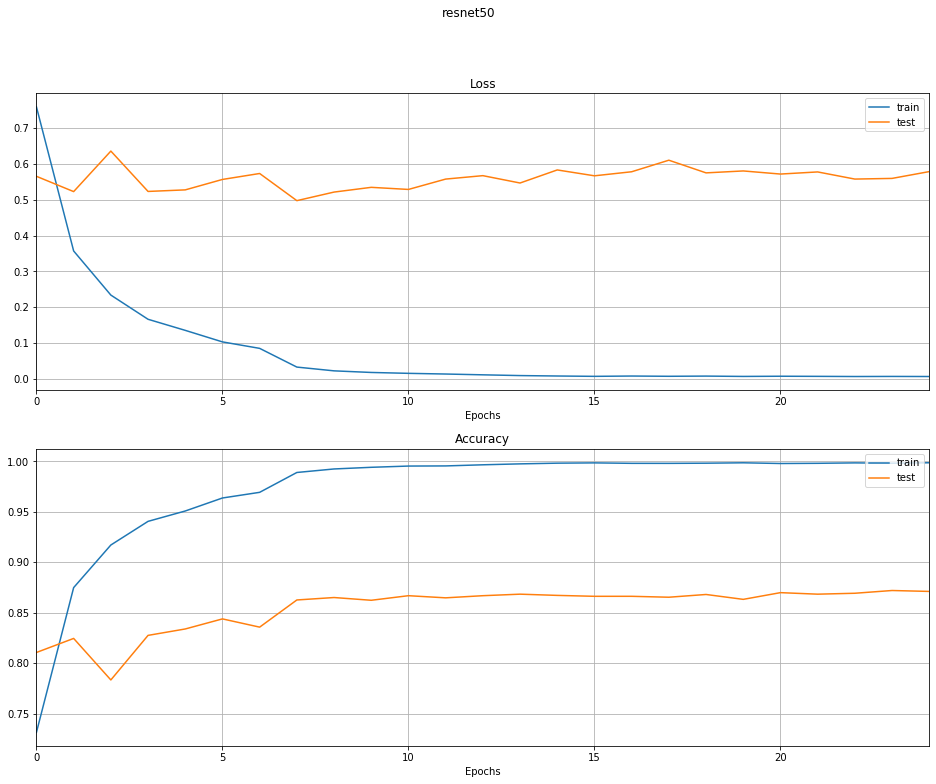

In [16]:
plot_learning_curve("nn/enriched_max/learning/resnet50.json")

In [118]:
pd.read_csv("nn/default/models_score.csv", sep=';')

,scope,resnet18,resnet50,inception_v3
0,total,85.02,86.11,84.36
1,nevus,94.70,94.83,93.98
2,pigmented benign keratosis,69.97,72.30,74.05
3,melanoma,51.77,58.08,47.98
4,basal cell carcinoma,80.61,75.76,83.64
5,actinic keratosis,64.86,62.16,31.67
6,vascular lesion,95.56,97.78,97.78
7,dermatofibroma,75.76,87.88,70.27
8,squamous cell carcinoma,53.33,60.00,75.76


In [77]:
def predict(img_path=None, model_name="inception_v3", path="nn/default/coeffs/inception_v3.pth"):
    img = Image.open(img_path)
    
    model = model_dict[model_name]
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 8)
    model.load_state_dict(torch.load(path))
    model.eval()
    
    img_input = transforms.Compose(data_transforms["test"])(img)
    img_input = img_input.unsqueeze(0)
    with torch.no_grad():
        output = model(img_input)
        _, predicted = torch.max(output.data, 1)
        proba = torch.nn.functional.softmax(output).tolist()[0]
        for i, p in enumerate(proba):
            print(f"{p : .10f} - {class_names[i]}")